Progetto di Linguistica Computazionale II

[Vincenzo Sammartino](https://www.linkedin.com/in/vincenzo-sammartino-0339191a1/ "Vincenzo Sammartino") - matricola 599203

Corso di Laurea Magistrale in Informatica Umanistica

# Lettura e preprocessing dei dataset

In [74]:
#Import delle librerie necessarie
import pandas as pd
import re
import conllu
from conllu import parse

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler

from sklearn.dummy import DummyClassifier

from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


import sqlite3

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from datasets import Dataset

import evaluate


Trasformo il file in modo da poter fare l'analisi con ProfilingUD

In [75]:
# Leggi il file TSV
file_tsv = "dati/haspeede2_dev_taskAB.tsv"
df = pd.read_csv(file_tsv, sep='\t', 
                 header=0, encoding='utf-8')
df.columns

Index(['id', 'text ', 'hs', 'stereotype'], dtype='object')

In [76]:
# Estrai la colonna 'text'
text_column = df['text ']
text_column

0       È terrorismo anche questo, per mettere in uno ...
1       @user @user infatti finché ci hanno guadagnato...
2       Corriere: Tangenti, Mafia Capitale dimenticata...
3       @user ad uno ad uno, perché quando i migranti ...
4       Il divertimento del giorno? Trovare i patrioti...
                              ...                        
6832    Gli stati nazionali devono essere pronti a rin...
6833    Il ministro dell'interno della Germania #Horst...
6834    #Salvini: In Italia troppi si sono montati la ...
6835    @user @user Chi giubila in buona fede non ha c...
6836    I giovani cristiani in #Etiopia sono indotti d...
Name: text , Length: 6837, dtype: object

In [77]:
output_file = "output_train.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    for text in text_column:
        f.write(text + '\n')

Leggo ora il file in formato ConLL

In [78]:
with open("output_train.conllu", "r", encoding="utf-8") as f:
    text = f.read()

# Rimuovi URL
text = re.sub(r'URL', '', text)

# Rimuovi @user
text = re.sub(r'@user', '', text)

sentences_train = conllu.parse(text)


In [79]:
with open("output_test_news.conllu", "r", encoding="utf-8") as f:
    text = f.read()

# Rimuovi URL
text = re.sub(r'URL', '', text)

# Rimuovi @user
text = re.sub(r'@user', '', text)

sentences_test = conllu.parse(text)

#Unisco i due array per fare i dizionari successivamente
sentences = sentences_train + sentences_test


In [80]:
#Controllo che il numero di frasi sia uguale al numero di etichette
len(sentences_test)


500

Leggo il file TSV di test

In [81]:
# Leggi il file TSV
file_tsv = "dati/haspeede2-test_taskAB-news.tsv"
df = pd.read_csv(file_tsv, sep='\t', encoding='utf-8',
                 names=["id", "testo"])
testo_test = df['testo']


file_tsv = "dati/haspeede2_reference_taskAB-news.tsv"
df = pd.read_csv(file_tsv, sep='\t', encoding='utf-8',
                 names=["id", "testo", "hs", "stereotype"])

y_test_hs = df['hs'].values #etichette per il test (hate speech)

# etichette per il test (stereotype)
y_test_stereotypes = df['stereotype'].values

testo_test


0      Andate pure là, tanto quei fessi degli italian...
1      Che fine spero che faccia il killer nigeriano ...
2       Così i profughi ci svuotano i negozi a Pordenone
3      Così umiliano gli italiani e coccolano i cland...
4      Danno soldi ai clandestini, ma ai disabili inv...
                             ...                        
495    Sea Watch, il pm fa sbarcare i migranti. Salvi...
496    Il pm fa sbarcare i migranti Il capo leghista ...
497    Pisa, il poster di Salvini con i migranti fatt...
498    Sea Watch e lo sbarco del migrante con una sol...
499    Decreto Sicurezza Bis, multe più salate per ch...
Name: testo, Length: 500, dtype: object

In [82]:
output_file = "output_test_news.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    for testo in testo_test:
        f.write(testo + '\n')


In [83]:
import numpy as np

with open('dati/haspeede2_dev_taskAB.tsv', 'r', encoding='utf-8') as file:
    # Salta la prima riga (header)
    file.readline()

    # Leggo le righe rimanenti
    lines = file.readlines()

    text = []
    hs = []
    stereotypes = []

    for line in lines:
        elements = line.split('\t')
        text.append(elements[1])
        hs.append(int(elements[2]))
        stereotypes.append(int(elements[3]))

    file.close()

text = np.array(text)
y_train_hs = np.array(hs)  # etichette per hate speech
y_train_stereotypes = np.array(stereotypes)  # etichette per stereotypes
np.unique(y_test_stereotypes,return_counts=True)

(array([0, 1], dtype=int64), array([325, 175], dtype=int64))

# Classificazione con le informazioni lessicali

In [84]:
# Leggi il file TSV di train
file_tsv = "dati/info_lessicali_train.csv"
df_train = pd.read_csv(file_tsv, sep='\t', encoding='utf-8')
#Rimuovo le colonne non necessarie
df_train = df_train.drop(['Filename', 'n_sentences'], axis=1)
df_train


,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,upos_dist_DET,upos_dist_INTJ,...,principal_proposition_dist,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5
0,22,22.0,4.950000,0.000000,13.636364,4.545455,4.545455,4.545455,13.636364,0.0,...,50.000000,50.000000,100.000000,0.000000,1.000000,100.000000,0.0,0.000000,0.0,0.0
1,18,18.0,4.882353,0.000000,11.111111,5.555556,16.666667,0.000000,5.555556,0.0,...,33.333333,66.666667,100.000000,0.000000,2.000000,0.000000,100.0,0.000000,0.0,0.0
2,14,14.0,6.000000,0.000000,7.142857,7.142857,0.000000,7.142857,0.000000,0.0,...,0.000000,100.000000,100.000000,0.000000,1.000000,100.000000,0.0,0.000000,0.0,0.0
3,22,22.0,4.800000,4.545455,22.727273,4.545455,0.000000,0.000000,13.636364,0.0,...,0.000000,100.000000,100.000000,0.000000,1.000000,100.000000,0.0,0.000000,0.0,0.0
4,26,26.0,5.181818,11.538462,11.538462,0.000000,0.000000,0.000000,23.076923,0.0,...,33.333333,66.666667,100.000000,0.000000,2.000000,0.000000,100.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,50,50.0,5.108696,6.000000,8.000000,4.000000,10.000000,2.000000,16.000000,0.0,...,16.666667,83.333333,100.000000,0.000000,1.666667,66.666667,0.0,33.333333,0.0,0.0
6835,55,55.0,4.288462,0.000000,14.545455,0.000000,1.818182,9.090909,21.818182,0.0,...,25.000000,75.000000,100.000000,0.000000,1.000000,100.000000,0.0,0.000000,0.0,0.0
6836,42,42.0,5.305556,2.380952,4.761905,2.380952,9.523810,4.761905,7.142857,0.0,...,25.000000,75.000000,0.000000,100.000000,1.000000,100.000000,0.0,0.000000,0.0,0.0
6837,40,40.0,4.368421,7.500000,7.500000,15.000000,12.500000,2.500000,10.000000,0.0,...,25.000000,75.000000,66.666667,33.333333,1.500000,50.000000,50.0,0.000000,0.0,0.0


In [85]:
# Leggi il file TSV di test
file_tsv = "dati/info_lessicali_test_news.csv"
df_test = pd.read_csv(file_tsv, sep='\t', encoding='utf-8')
# Rimuovo le colonne non necessarie
df_test = df_test.drop(['Filename', 'n_sentences'], axis=1)
df_test

,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,upos_dist_DET,upos_dist_INTJ,...,dep_dist_root,dep_dist_xcomp,principal_proposition_dist,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3
0,19,19.0,5.312500,0.000000,5.263158,15.789474,0.000000,0.000000,15.789474,0.0,...,5.263158,0.000000,33.333333,66.666667,0.0,100.0,2.0,0.0,100.0,0.0
1,23,23.0,4.095238,13.043478,8.695652,4.347826,0.000000,0.000000,26.086957,0.0,...,4.347826,0.000000,50.000000,50.000000,100.0,0.0,1.0,100.0,0.0,0.0
2,9,9.0,4.444444,0.000000,11.111111,11.111111,0.000000,0.000000,22.222222,0.0,...,11.111111,0.000000,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,24,24.0,4.789474,0.000000,8.333333,4.166667,0.000000,8.333333,20.833333,0.0,...,4.166667,0.000000,50.000000,50.000000,0.0,100.0,1.0,100.0,0.0,0.0
4,25,25.0,4.750000,12.000000,12.000000,0.000000,0.000000,8.000000,16.000000,0.0,...,4.000000,0.000000,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,18,18.0,4.200000,0.000000,0.000000,0.000000,5.555556,0.000000,16.666667,0.0,...,5.555556,5.555556,33.333333,66.666667,100.0,0.0,1.0,100.0,0.0,0.0
496,12,12.0,4.083333,8.333333,8.333333,0.000000,0.000000,0.000000,25.000000,0.0,...,8.333333,8.333333,33.333333,66.666667,100.0,0.0,1.0,100.0,0.0,0.0
497,20,20.0,4.533333,0.000000,15.000000,0.000000,5.000000,0.000000,15.000000,0.0,...,5.000000,0.000000,0.000000,100.000000,100.0,0.0,2.0,0.0,100.0,0.0
498,22,22.0,4.000000,4.545455,9.090909,0.000000,4.545455,4.545455,22.727273,0.0,...,4.545455,0.000000,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Prendo i due dataframe con diverso numero di colonne e trovo le colonne comuni
common_columns = list(set(df_train.columns) & set(df_test.columns))

# Seleziona solo le colonne comuni per entrambi i dataframe
X_train = df_train[common_columns]
X_test = df_test[common_columns]

## Normalizzazione

In [87]:
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Baseline (Dummy Classifier)

In [88]:
dummy_clf = DummyClassifier(strategy='prior', random_state=42)
dummy_clf.fit(X_train, y_train_hs)
y_pred = dummy_clf.predict(X_test)

print(classification_report(y_test_hs, y_pred))


              precision    recall  f1-score   support

           0       0.64      1.00      0.78       319
           1       0.00      0.00      0.00       181

    accuracy                           0.64       500
   macro avg       0.32      0.50      0.39       500
weighted avg       0.41      0.64      0.50       500



c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [89]:
dummy_clf = DummyClassifier(strategy='prior', random_state=42)
dummy_clf.fit(X_train, y_train_stereotypes)
y_pred = dummy_clf.predict(X_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79       325
           1       0.00      0.00      0.00       175

    accuracy                           0.65       500
   macro avg       0.33      0.50      0.39       500
weighted avg       0.42      0.65      0.51       500



c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## HyperParameters Tuning

In [ ]:

# Inizializzo LinearSVC
clf = LinearSVC(max_iter=10000)

# defining parameter range
# Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "dual": [True, False]
}

RSKF = RepeatedStratifiedKFold(
    n_splits=20,
    n_repeats=3,
    random_state=0
)

grid = RandomizedSearchCV(
    clf,
    n_iter=1500,
    param_distributions=param_grid,
    cv=RSKF,
    n_jobs=-1,
    refit=True,
    verbose=2,
    random_state=0
)

# fitting the model for grid search
grid.fit(X_train, y_train_hs)


In [ ]:
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print(grid.best_score_)


In [ ]:
grid_scores = pd.DataFrame(grid.cv_results_)
grid_scores


In [ ]:
sns.set(rc={'figure.figsize': (9, 5)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3)

sns.pointplot(
    data=grid_scores,
    x="param_C",
    y="mean_test_score",
    hue="param_dual"
)

plt.savefig("linearSVC_C_param.svg")


In [ ]:
clf = LinearSVC(max_iter=10000, C=0.001, dual=False)
clf.fit(X_train, y_train_hs)

y_pred = clf.predict(X_test)
print(classification_report(y_test_hs, y_pred))


In [ ]:
scores = cross_val_score(clf, X_test, y_test_hs, cv=5)
print(scores)
print('media:', np.mean(scores))


Estrazione delle features più importanti ai fini della classificazione per il modello LinearSVM

In [ ]:
feat_imp = abs(clf.coef_).transpose()
feat_imp = np.mean(feat_imp, axis=1)

df_feat_imp = pd.DataFrame(
    feat_imp, index=X_train.columns, columns=["% importanza"])
df_feat_imp = df_feat_imp.sort_values("% importanza", ascending=False)
df_feat_imp[:15]


In [ ]:
sns.set(rc={'figure.figsize': (9, 5)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3)

sns.barplot(
    data=df_feat_imp[:15],
    x="% importanza",
    y=df_feat_imp.index[:15],
    orient='h',
    palette="deep"
)

plt.savefig("linearSVC_features.svg")


# Rappresentazione esplicita del testo - Bag of Words (forme)

In [90]:
# Creazione dei dizionari di conteggio delle parole
# Creazione dei dizionari di conteggio delle parole
dict_list = [dict   (Counter([token["form"] for token in sentence]))
             for sentence in sentences]


In [91]:
# Funzioni per filtrare le parole poco frequenti e separare i dati di training e test
def compute_word_frequency(dict_list):
    word_frequency = {}
    for d in dict_list:
        for word, count in d.items():
            word_frequency[word] = word_frequency.get(word, 0) + count
    return word_frequency


def split_and_remove_infrequent_words(dict_list, train_size, min_frequency):
    word_frequency = compute_word_frequency(dict_list)
    train_dict_list = []
    test_dict_list = []

    for i, d in enumerate(dict_list):
        filtered_dict = {word: count for word, count in d.items(
        ) if word_frequency[word] >= min_frequency}
        if i < train_size:
            train_dict_list.append(filtered_dict)
        else:
            test_dict_list.append(filtered_dict)

    return {"train": train_dict_list, "test": test_dict_list}


In [92]:
# Filtraggio delle parole e separazione dei dati di training e test
train_size = 6839
filtered_data = split_and_remove_infrequent_words(dict_list, train_size, 5)

train_data = filtered_data["train"]
test_data = filtered_data["test"]

# Creazione del vettorizzatore e trasformazione dei dati
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)


In [93]:
clf = LinearSVC(max_iter=10000, C=0.001, dual=False)
clf.fit(X_train, y_train_stereotypes)
y_pred = clf.predict(X_test)
print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.98      0.80       325
           1       0.80      0.11      0.20       175

    accuracy                           0.68       500
   macro avg       0.74      0.55      0.50       500
weighted avg       0.72      0.68      0.59       500



In [94]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()


In [95]:
coefs = clf.coef_
coefs.shape


(1, 3750)

Feature importance classe 0


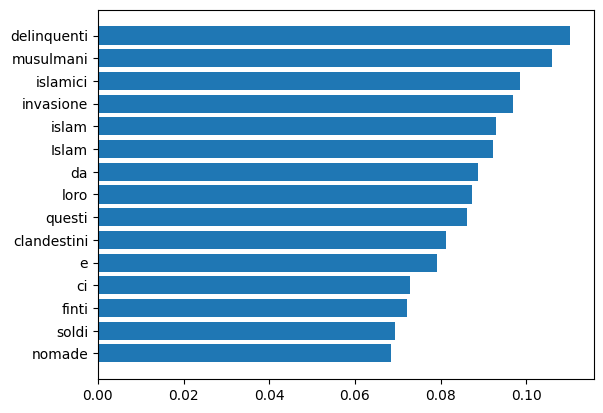

In [96]:
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name,
                       coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(
    sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 15
print(f'Feature importance classe {clf.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())
         [:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(
    sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()

plt.savefig('coefs_bow.svg')


In [97]:
scores = cross_val_score(clf, X_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.67 0.64 0.69 0.65 0.65]
media: 0.6599999999999999


# Bag of Words (lemmi)

In [98]:
# Creazione dei dizionari di conteggio delle parole
# Creazione dei dizionari di conteggio delle parole
dict_list = [dict   (Counter([token["lemma"] for token in sentence]))
             for sentence in sentences]


In [99]:
# Funzioni per filtrare le parole poco frequenti e separare i dati di training e test
def compute_word_frequency(dict_list):
    word_frequency = {}
    for d in dict_list:
        for word, count in d.items():
            word_frequency[word] = word_frequency.get(word, 0) + count
    return word_frequency


def split_and_remove_infrequent_words(dict_list, train_size, min_frequency):
    word_frequency = compute_word_frequency(dict_list)
    train_dict_list = []
    test_dict_list = []

    for i, d in enumerate(dict_list):
        filtered_dict = {word: count for word, count in d.items(
        ) if word_frequency[word] >= min_frequency}
        if i < train_size:
            train_dict_list.append(filtered_dict)
        else:
            test_dict_list.append(filtered_dict)

    return {"train": train_dict_list, "test": test_dict_list}


In [100]:
# Filtraggio delle parole e separazione dei dati di training e test
train_size = 6839
filtered_data = split_and_remove_infrequent_words(dict_list, train_size, 5)

train_data = filtered_data["train"]
test_data = filtered_data["test"]

# Creazione del vettorizzatore e trasformazione dei dati
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)


In [101]:
clf = LinearSVC(max_iter=10000, C=0.001, dual=False)
clf.fit(X_train, y_train_stereotypes)
y_pred = clf.predict(X_test)
print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.97      0.79       325
           1       0.66      0.11      0.19       175

    accuracy                           0.67       500
   macro avg       0.66      0.54      0.49       500
weighted avg       0.66      0.67      0.58       500



In [102]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()


In [103]:
coefs = clf.coef_
coefs.shape


(1, 2929)

Feature importance classe 0


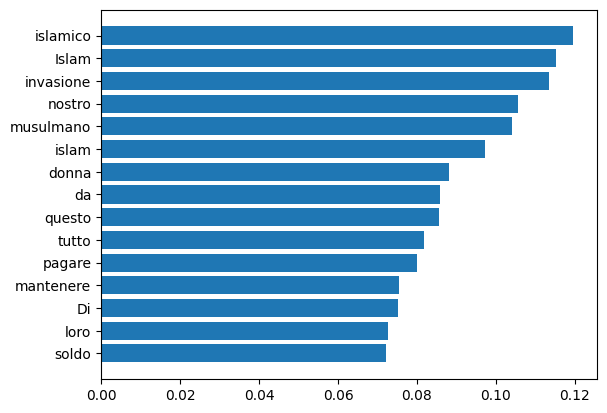

In [104]:
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name,
                       coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(
    sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 15
print(f'Feature importance classe {clf.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())
         [:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(
    sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()

plt.savefig('coefs_bow_lemmi.svg')


In [105]:
scores = cross_val_score(clf, X_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.66 0.64 0.67 0.65 0.65]
media: 0.654


# N-grammi di caratteri

In [106]:
def conllu_sentences_to_strings(sentences):
    return [' '.join([token["form"] for token in sentence]) for sentence in sentences]


def extract_char_ngrams(sentences, n):
    # Join the words in the sentences with spaces
    all_words = ' '.join(sentences)

    # Extract n-grams of characters
    ngram_chars = [all_words[i:i + n] for i in range(len(all_words) - n + 1)]

    # Add the prefix 'CHAR_n_' to each n-gram and count their frequencies
    char_ngrams = Counter(
        {f'CHAR_{n}_{ngram}': count for ngram, count in Counter(ngram_chars).items()})

    return char_ngrams


sentence_strings = conllu_sentences_to_strings(sentences)

# Dopo 6 caratteri non si ottengono miglioramenti
char_ngrams = extract_char_ngrams(sentence_strings, 6)

train_size = 6839
test_size = 500

train_sentences = sentence_strings[:train_size]
test_sentences = sentence_strings[train_size:train_size + test_size]


In [107]:
len(char_ngrams)

277416

In [108]:
# Convertire le frasi CoNLL-U in una lista di stringhe
train_strings = conllu_sentences_to_strings(sentences_train)
test_strings = conllu_sentences_to_strings(sentences_test)

# Creare un CountVectorizer per gli n-grammi di caratteri
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 6))

# Trasformare le frasi in una matrice delle feature
X_train = vectorizer.fit_transform(train_strings)
X_test = vectorizer.transform(test_strings)

# Addestrare e valutare il modello LinearSVC
clf = LinearSVC(max_iter=10000, C=0.001, dual=False)
clf.fit(X_train, y_train_stereotypes)
y_pred = clf.predict(X_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.93      0.82       325
           1       0.75      0.37      0.50       175

    accuracy                           0.74       500
   macro avg       0.74      0.65      0.66       500
weighted avg       0.74      0.74      0.71       500



In [109]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names


[' ',
 ' !',
 ' ! ',
 ' ! !',
 ' ! ! ',
 ' ! ! !',
 ' ! ! #',
 ' ! ! ,',
 ' ! ! a',
 ' ! ! b',
 ' ! ! c',
 ' ! ! d',
 ' ! ! e',
 ' ! ! f',
 ' ! ! g',
 ' ! ! i',
 ' ! ! m',
 ' ! ! n',
 ' ! ! o',
 ' ! ! p',
 ' ! ! q',
 ' ! ! r',
 ' ! ! s',
 ' ! ! t',
 ' ! ! v',
 ' ! ! x',
 ' ! ! è',
 ' ! ! �',
 ' ! ! 😂',
 ' ! ! 😤',
 ' ! ! 😲',
 ' ! !!',
 ' ! !! ',
 ' ! !!!',
 ' ! !!.',
 ' ! !!1',
 ' ! !!i',
 ' ! !!m',
 ' ! !!s',
 ' ! !!u',
 ' ! !!👎',
 ' ! !!😡',
 ' ! !b',
 ' ! !bi',
 ' ! !c',
 ' ! !ca',
 ' ! !ce',
 ' ! !d',
 ' ! !di',
 ' ! !e',
 ' ! !e ',
 ' ! !f',
 ' ! !fo',
 ' ! !m',
 ' ! !ma',
 ' ! !n',
 ' ! !no',
 ' ! !q',
 ' ! !qu',
 ' ! !r',
 ' ! !ri',
 ' ! !s',
 ' ! !sc',
 ' ! !so',
 ' ! !v',
 ' ! !vo',
 ' ! !🇮',
 ' ! !🇮🇹',
 ' ! !👍',
 ' ! !👍👍',
 ' ! !👿',
 ' ! !😀',
 ' ! !😀👍',
 ' ! "',
 ' ! " ',
 ' ! " "',
 ' ! " (',
 ' ! " ,',
 ' ! " -',
 ' ! " 2',
 ' ! " i',
 ' ! " n',
 ' ! " u',
 ' ! #',
 ' ! # ',
 ' ! # a',
 ' ! # d',
 ' ! # i',
 ' ! # m',
 ' ! # r',
 ' ! # s',
 ' ! #1',
 ' ! #15',
 ' ! #2',
 ' ! 

In [110]:
coefs = clf.coef_
coefs.shape


(1, 368097)

Feature importance classe 0


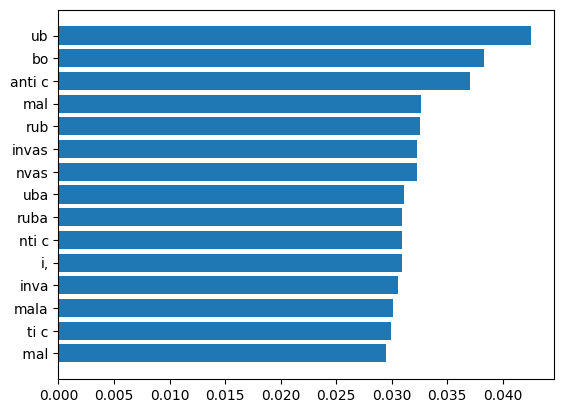

In [111]:
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name,
                       coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(
    sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 15
print(f'Feature importance classe {clf.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())
         [:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(
    sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()
plt.savefig("coefs_n_grammi_caratteri.svg")


In [112]:
scores = cross_val_score(clf, X_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.79 0.75 0.76 0.7  0.85]
media: 0.77


# N-grammi di parole

In [113]:
# Convertire le frasi CoNLL-U in una lista di stringhe
train_strings = conllu_sentences_to_strings(sentences_train)
test_strings = conllu_sentences_to_strings(sentences_test)

# Creare un CountVectorizer per gli n-grammi di parole (fino a 6)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 6))

# Trasformare le frasi in una matrice delle feature
X_train = vectorizer.fit_transform(train_strings)
X_test = vectorizer.transform(test_strings)

# Addestrare e valutare il modello LinearSVC
clf = LinearSVC(max_iter=10000, C=0.001, dual=False)
clf.fit(X_train, y_train_stereotypes)
y_pred = clf.predict(X_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.98      0.81       325
           1       0.84      0.15      0.25       175

    accuracy                           0.69       500
   macro avg       0.76      0.57      0.53       500
weighted avg       0.74      0.69      0.61       500



In [114]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names


['00',
 '00 come',
 '00 come in',
 '00 come in altre',
 '00 come in altre città',
 '00 come in altre città italiane',
 '00 dica',
 '00 dica una',
 '00 dica una parola',
 '00 dica una parola per',
 '00 dica una parola per le',
 '00 euro',
 '00 euro ma',
 '00 euro ma dove',
 '00 euro ma dove cazzo',
 '00 euro ma dove cazzo vogliamo',
 '00 per',
 '00 per lo',
 '00 per lo smantellamento',
 '00 per lo smantellamento del',
 '00 per lo smantellamento del di',
 '00 unità',
 '000',
 '000 00',
 '000 00 per',
 '000 00 per lo',
 '000 00 per lo smantellamento',
 '000 00 per lo smantellamento del',
 '000 000',
 '000 000 000',
 '000 000 000 trentasei',
 '000 000 000 trentasei miliardi',
 '000 000 000 trentasei miliardi in',
 '000 000 di',
 '000 000 di molto',
 '000 000 di molto poveri',
 '000 000 di persone',
 '000 000 di poveri',
 '000 000 di poveri centinaia',
 '000 000 di poveri centinaia di',
 '000 000 di stranieri',
 '000 000 di stranieri residenti',
 '000 000 di stranieri residenti in',
 '000 0

In [115]:
coefs = clf.coef_
coefs.shape

(1, 581911)

Feature importance classe 0


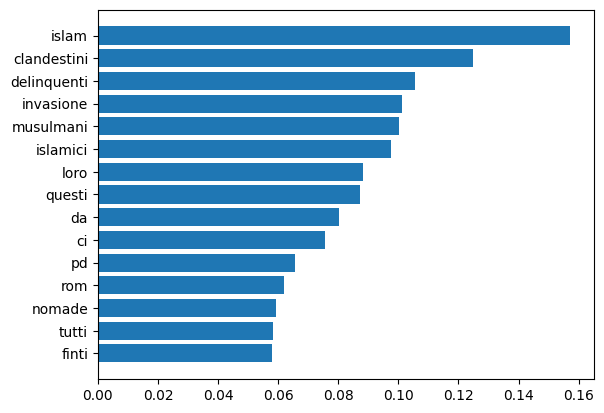

In [116]:
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name,
                       coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(
    sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 15
print(f'Feature importance classe {clf.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())
         [:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(
    sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()

plt.savefig('coefs_ngrammi_parole.svg')

In [117]:
scores = cross_val_score(clf, X_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.68 0.67 0.68 0.67 0.68]
media: 0.676


# N-grammi di PoS

In [118]:
# Extract POS tags from the parsed sentences
pos_tags = [[token['upos'] for token in sentence] for sentence in sentences]


In [119]:
def generate_pos_ngrams(pos_tags, max_n):
    ngrams = []
    for n in range(1, max_n + 1):
        ngrams.extend(pos_tags[i:i + n] for i in range(len(pos_tags) - n + 1))
    return ngrams

# Generazione degli n-grammi di POS tags (fino a 6-grammi)
pos_ngrams = [generate_pos_ngrams(sentence_tags, 6)
              for sentence_tags in pos_tags]

# Conversione degli n-grammi di POS tags in stringhe separate da "_"
pos_bigrams_str = [' '.join(['_'.join(ngram) for ngram in sentence_ngrams])
                   for sentence_ngrams in pos_ngrams]

# Creazione di un CountVectorizer con un tokenizzatore personalizzato (divisione sullo spazio bianco)
vectorizer = CountVectorizer(tokenizer=lambda x: x.split())


In [120]:
# Trasformazione degli n-grammi di POS tags in una matrice delle feature
X = vectorizer.fit_transform(pos_bigrams_str)

# Addestramento e valutazione del classificatore
train_size = 6839
clf = LinearSVC(max_iter=10000, C=0.001, dual=False)
clf.fit(X[:train_size], y_train_stereotypes)
y_pred = clf.predict(X[train_size:])

print(classification_report(y_test_stereotypes, y_pred))


c:\Users\vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.65      0.92      0.76       325
           1       0.40      0.10      0.16       175

    accuracy                           0.63       500
   macro avg       0.53      0.51      0.46       500
weighted avg       0.57      0.63      0.55       500



In [121]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names


['_',
 '__adj',
 '__adj_det',
 '__adj_det_adv',
 '__adj_det_adv_verb',
 '__adj_det_adv_verb_pron',
 '__adj_det_noun',
 '__adj_det_noun_pron',
 '__adj_det_noun_pron_verb',
 '__adj_det_noun_punct',
 '__adj_det_noun_punct_adv',
 '__adj_det_noun_punct_aux',
 '__adj_det_noun_punct_propn',
 '__adj_det_propn',
 '__adj_det_propn_det',
 '__adj_det_propn_det_noun',
 '__adj_det_propn_propn',
 '__adj_det_propn_propn_propn',
 '__adj_det_propn_punct',
 '__adj_det_propn_punct_adp',
 '__adj_pron',
 '__adj_pron_pron',
 '__adj_pron_pron_punct',
 '__adj_pron_pron_punct_verb',
 '__adj_pron_punct',
 '__adj_pron_punct_aux',
 '__adj_pron_punct_aux_det',
 '__adj_pron_verb',
 '__adj_pron_verb_adp',
 '__adj_pron_verb_adp_det',
 '__adp',
 '__adp_det',
 '__adp_det__',
 '__adp_det___adp',
 '__adp_det___adp_det',
 '__adp_det___propn',
 '__adp_det___propn_det',
 '__adp_det___propn_pron',
 '__adp_det___verb',
 '__adp_det___verb_adv',
 '__adp_det___verb_det',
 '__adp_det___verb_pron',
 '__adp_det_adj',
 '__adp_det_adj

In [122]:
coefs = clf.coef_
coefs.shape


(1, 141846)

Feature importance classe 0


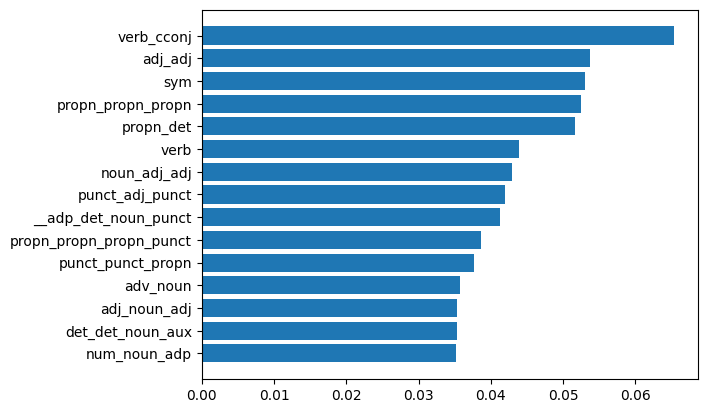

In [123]:
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name,
                       coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(
    sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 15
print(f'Feature importance classe {clf.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())
         [:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(
    sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()


plt.savefig('coefs_ngrammi_pos.svg')


In [124]:
scores = cross_val_score(clf, X_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.68 0.67 0.68 0.67 0.68]
media: 0.676


# Word Embeddings (itWac)

### Embeddings singolo (128 elementi)

In [125]:
conn = sqlite3.connect("embeddings/itwac128.sqlite")
c = conn.cursor()

dizionario = {}
# Eseguo la query per estrarre le parole e i relativi embeddings
for row in c.execute("SELECT * from store"):
    if row[0] != "\t":
        dizionario[row[0]] = row[1:129]



In [126]:
len(dizionario)

1247492

In [127]:
def conllu_sentences_to_strings(sentences):
    return [' '.join([token["form"] for token in sentence]) for sentence in sentences]


sentence_strings = conllu_sentences_to_strings(sentences)
testo_addestramento = pd.Series(sentence_strings)

# Calcolo degli embedding delle frasi come media degli embedding delle parole (ogni documento è rappresentato da un vettore di 128 elementi)
embeddings_train = []
for text in testo_addestramento[:6839]:
    words = text.split()
    text_embedding = np.mean([dizionario[word]
                             for word in words if word in dizionario], axis=0)
    embeddings_train.append(text_embedding)

embeddings_test = []
for text in testo_addestramento[6839:]:
    words = text.split()
    text_embedding = np.mean([dizionario[word]
                             for word in words if word in dizionario], axis=0)
    embeddings_test.append(text_embedding)

train_size = 6839
clf = LinearSVC()
clf.fit(embeddings_train, y_train_stereotypes)
y_pred = clf.predict(embeddings_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.92      0.80       325
           1       0.66      0.30      0.41       175

    accuracy                           0.70       500
   macro avg       0.68      0.61      0.60       500
weighted avg       0.69      0.70      0.66       500



In [128]:
scores = cross_val_score(clf, embeddings_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.8  0.71 0.69 0.66 0.76]
media: 0.724


### 3 Embeddings congiunti usando aggettivi, sostantivi e verbi

In [129]:
def conllu_sentences_to_categorized_words(sentences):
    categorized_words = []
    for sentence in sentences:
        nouns = [token["form"]
                 for token in sentence if token["upos"] == "NOUN"]
        adjectives = [token["form"]
                      for token in sentence if token["upos"] == "ADJ"]
        verbs = [token["form"]
                 for token in sentence if token["upos"] == "VERB"]
        categorized_words.append((nouns, adjectives, verbs))
    return categorized_words


categorized_words = conllu_sentences_to_categorized_words(sentences)
categorized_words


[(['terrorismo', 'stato', 'soggezione', 'persone', 'innocue'],
  [],
  ['mettere', 'render']),
 (['campi', '#rom', 'ok'], [], ['', 'guadagnato']),
 (['buche', 'campi', 'rom'], [], ['dimenticataMazzette']),
 (['migranti', 'terra'], ['israeliti'], ['arrivarono', 'fecero']),
 (['divertimento', 'giorno', 'patrioti', 'rom', 'spesa'],
  ['italiani', 'multinazionale', 'tedesca'],
  ['Trovare', 'inneggiano', 'facendo']),
 (['benzina', 'nomadi', 'figli', 'scuola', 'giunta'], [], ['paga', 'portano']),
 (['islam', 'cristianesimo', 'c', 'ignorante'], ['...a'], ['sorbire']),
 (['grazie', 'stavo', 'campi', 'rom'],
  ['giusto'],
  ['', 'caricando', 'messo', 'avallava', 'finanziare']),
 (['italiani', 'strada'],
  ['innocenti'],
  ['smettetela', 'dire', 'trattati', 'uccidevano']),
 (['Minorenne', 'rom', 'furto', 'appartamento'], [], ['arrestato']),
 (['Studentessa', 'nomade', '20anni', 'nomade', 'campo'],
  ['cinese', 'vicino', 'nomade'],
  ['morta', 'fermato', 'denunciato']),
 (['Ddl', 'velo', 'apolog

In [130]:
nouns_list = [word[0] for word in categorized_words]
adjectives_list = [word[1] for word in categorized_words]
verbs_list = [word[2] for word in categorized_words]

nouns_vector = np.array([word[0] for word in categorized_words], dtype=object)
adjectives_vector = np.array([word[1]
                             for word in categorized_words], dtype=object)
verbs_vector = np.array([word[2] for word in categorized_words], dtype=object)

In [131]:
def calculate_embeddings(words_list, dictionary, embedding_size=128):
    if not words_list:
        return np.zeros(embedding_size)
    embeddings = [dictionary[word]
                  for word in words_list if word in dictionary]
    if not embeddings:
        return np.zeros(embedding_size)
    return np.mean(embeddings, axis=0)


embeddings_train = []
for words_set in categorized_words[:6839]:
    nouns_embedding = calculate_embeddings(words_set[0], dizionario)
    adjectives_embedding = calculate_embeddings(words_set[1], dizionario)
    verbs_embedding = calculate_embeddings(words_set[2], dizionario)
    combined_embedding = np.concatenate(
        [nouns_embedding, adjectives_embedding, verbs_embedding])
    embeddings_train.append(combined_embedding)

embeddings_test = []
for words_set in categorized_words[6839:]:
    nouns_embedding = calculate_embeddings(words_set[0], dizionario)
    adjectives_embedding = calculate_embeddings(words_set[1], dizionario)
    verbs_embedding = calculate_embeddings(words_set[2], dizionario)
    combined_embedding = np.concatenate(
        [nouns_embedding, adjectives_embedding, verbs_embedding])
    embeddings_test.append(combined_embedding)

print(len(embeddings_test[0]))


384


In [132]:
clf = LinearSVC()
clf.fit(embeddings_train, y_train_stereotypes)
y_pred = clf.predict(embeddings_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.86      0.79       325
           1       0.62      0.42      0.50       175

    accuracy                           0.71       500
   macro avg       0.68      0.64      0.65       500
weighted avg       0.70      0.71      0.69       500



In [133]:
scores = cross_val_score(clf, embeddings_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.65 0.62 0.64 0.65 0.77]
media: 0.666


# Word Embeddings (Twitter)

### Embeddings singolo (128 elementi)

In [134]:
conn = sqlite3.connect("embeddings/twitter128.sqlite")
c = conn.cursor()

dizionario = {}
# Eseguo la query per estrarre le parole e i relativi embeddings
for row in c.execute("SELECT * from store"):
    if row[0] != "\t":
        dizionario[row[0]] = row[1:129]



In [135]:
len(dizionario)

1188949

In [136]:
def conllu_sentences_to_strings(sentences):
    return [' '.join([token["form"] for token in sentence]) for sentence in sentences]


sentence_strings = conllu_sentences_to_strings(sentences)
testo_addestramento = pd.Series(sentence_strings)

# Calcolo degli embedding delle frasi come media degli embedding delle parole (ogni documento è rappresentato da un vettore di 128 elementi)
embeddings_train = []
for text in testo_addestramento[:6839]:
    words = text.split()
    text_embedding = np.mean([dizionario[word]
                             for word in words if word in dizionario], axis=0)
    embeddings_train.append(text_embedding)

embeddings_test = []
for text in testo_addestramento[6839:]:
    words = text.split()
    text_embedding = np.mean([dizionario[word]
                             for word in words if word in dizionario], axis=0)
    embeddings_test.append(text_embedding)

train_size = 6839
clf = LinearSVC()
clf.fit(embeddings_train, y_train_stereotypes)
y_pred = clf.predict(embeddings_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.92      0.81       325
           1       0.68      0.33      0.45       175

    accuracy                           0.71       500
   macro avg       0.70      0.62      0.63       500
weighted avg       0.71      0.71      0.68       500



In [137]:
scores = cross_val_score(clf, embeddings_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.77 0.73 0.72 0.69 0.79]
media: 0.74


### 3 Embeddings congiunti usando aggettivi, sostantivi e verbi

In [138]:
def conllu_sentences_to_categorized_words(sentences):
    categorized_words = []
    for sentence in sentences:
        nouns = [token["form"]
                 for token in sentence if token["upos"] == "NOUN"]
        adjectives = [token["form"]
                      for token in sentence if token["upos"] == "ADJ"]
        verbs = [token["form"]
                 for token in sentence if token["upos"] == "VERB"]
        categorized_words.append((nouns, adjectives, verbs))
    return categorized_words


categorized_words = conllu_sentences_to_categorized_words(sentences)
categorized_words


[(['terrorismo', 'stato', 'soggezione', 'persone', 'innocue'],
  [],
  ['mettere', 'render']),
 (['campi', '#rom', 'ok'], [], ['', 'guadagnato']),
 (['buche', 'campi', 'rom'], [], ['dimenticataMazzette']),
 (['migranti', 'terra'], ['israeliti'], ['arrivarono', 'fecero']),
 (['divertimento', 'giorno', 'patrioti', 'rom', 'spesa'],
  ['italiani', 'multinazionale', 'tedesca'],
  ['Trovare', 'inneggiano', 'facendo']),
 (['benzina', 'nomadi', 'figli', 'scuola', 'giunta'], [], ['paga', 'portano']),
 (['islam', 'cristianesimo', 'c', 'ignorante'], ['...a'], ['sorbire']),
 (['grazie', 'stavo', 'campi', 'rom'],
  ['giusto'],
  ['', 'caricando', 'messo', 'avallava', 'finanziare']),
 (['italiani', 'strada'],
  ['innocenti'],
  ['smettetela', 'dire', 'trattati', 'uccidevano']),
 (['Minorenne', 'rom', 'furto', 'appartamento'], [], ['arrestato']),
 (['Studentessa', 'nomade', '20anni', 'nomade', 'campo'],
  ['cinese', 'vicino', 'nomade'],
  ['morta', 'fermato', 'denunciato']),
 (['Ddl', 'velo', 'apolog

In [139]:
nouns_list = [word[0] for word in categorized_words]
adjectives_list = [word[1] for word in categorized_words]
verbs_list = [word[2] for word in categorized_words]

nouns_vector = np.array([word[0] for word in categorized_words], dtype=object)
adjectives_vector = np.array([word[1]
                             for word in categorized_words], dtype=object)
verbs_vector = np.array([word[2] for word in categorized_words], dtype=object)

In [140]:
def calculate_embeddings(words_list, dictionary, embedding_size=128):
    if not words_list:
        return np.zeros(embedding_size)
    embeddings = [dictionary[word]
                  for word in words_list if word in dictionary]
    if not embeddings:
        return np.zeros(embedding_size)
    return np.mean(embeddings, axis=0)


embeddings_train = []
for words_set in categorized_words[:6839]:
    nouns_embedding = calculate_embeddings(words_set[0], dizionario)
    adjectives_embedding = calculate_embeddings(words_set[1], dizionario)
    verbs_embedding = calculate_embeddings(words_set[2], dizionario)
    combined_embedding = np.concatenate(
        [nouns_embedding, adjectives_embedding, verbs_embedding])
    embeddings_train.append(combined_embedding)

embeddings_test = []
for words_set in categorized_words[6839:]:
    nouns_embedding = calculate_embeddings(words_set[0], dizionario)
    adjectives_embedding = calculate_embeddings(words_set[1], dizionario)
    verbs_embedding = calculate_embeddings(words_set[2], dizionario)
    combined_embedding = np.concatenate(
        [nouns_embedding, adjectives_embedding, verbs_embedding])
    embeddings_test.append(combined_embedding)

print(len(embeddings_test[0]))


384


In [141]:
clf = LinearSVC()
clf.fit(embeddings_train, y_train_stereotypes)
y_pred = clf.predict(embeddings_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.85      0.78       325
           1       0.59      0.39      0.47       175

    accuracy                           0.69       500
   macro avg       0.65      0.62      0.62       500
weighted avg       0.67      0.69      0.67       500



In [142]:
scores = cross_val_score(clf, embeddings_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.71 0.65 0.65 0.65 0.72]
media: 0.6759999999999999


# Word Embeddings con Word2Vec

In [143]:
from gensim.models import Word2Vec


def conllu_sentences_to_strings(sentences):
    return [' '.join([token["form"] for token in sentence]) for sentence in sentences]


sentence_strings = conllu_sentences_to_strings(sentences)
testo_addestramento = pd.Series(sentence_strings)

# Addestramento del modello Word2Vec con CBOW con un contesto di parole pari a 5
word2vec_model = Word2Vec(sentences=testo_addestramento,
                          vector_size=128, window=5, min_count=1, workers=8)

# Calcolo degli embedding delle frasi come media degli embedding delle parole
embeddings_train = []
for text in testo_addestramento[:6839]:
    text_embedding = np.mean([word2vec_model.wv[word]
                             for word in text], axis=0)
    embeddings_train.append(text_embedding)

embeddings_test = []
for text in testo_addestramento[6839:]:
    text_embedding = np.mean([word2vec_model.wv[word]
                             for word in text], axis=0)
    embeddings_test.append(text_embedding)

train_size = 6839
clf = LinearSVC()
clf.fit(embeddings_train, y_train_stereotypes)
y_pred = clf.predict(embeddings_test)

print(classification_report(y_test_stereotypes, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.91      0.78       325
           1       0.54      0.19      0.29       175

    accuracy                           0.66       500
   macro avg       0.61      0.55      0.53       500
weighted avg       0.63      0.66      0.60       500



In [144]:
scores = cross_val_score(clf, embeddings_test, y_test_stereotypes, cv=5)
print(scores)
print('media:', np.mean(scores))


[0.73 0.63 0.77 0.66 0.71]
media: 0.7
